# Spectrometer Controller
OceanInsight [Redtide - USB2000](https://www.oceanoptics.com/resources/legacy-spectrometers/) \
[SeaBreeze](https://github.com/ap--/python-seabreeze/tree/main) 

### Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import time
import threading

from pycolorgradient.main import custom_multicolor_cmap # custom color gradient function
# For helper functions
from datetime import datetime, timezone
import h5py

Load Spectrometer
- Be sure to run "seabreeze_os_setup" in the terminal inside the conda environment after installing seabreeze
- If you are on wsl, you will have to bind the usb to wsl. This will only work on Windows 11 on WSL2. Linux or Mac highly recommended

Run "usbipd attach --wsl --busid 5-1" in PowerShell

Run "lsusb" in wsl

In [4]:
import seabreeze
from seabreeze.spectrometers import Spectrometer, list_devices
devices = list_devices()
print(devices)
spec = Spectrometer.from_first_available()

[<SeaBreezeDevice USB2000:USB2G50689>]


### Take a spectra

Text(0, 0.5, 'Intensity')

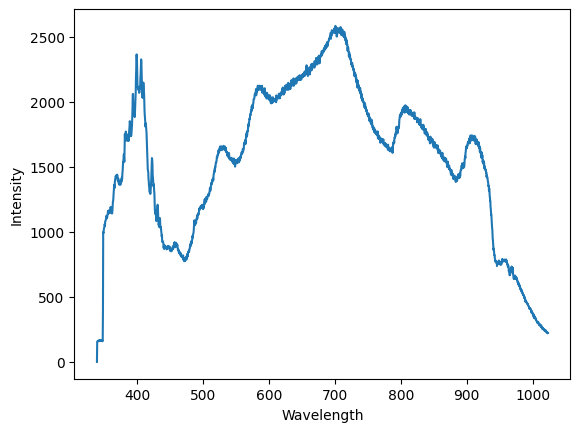

In [14]:
# Set integration time
spec.integration_time_micros(10000)  # 0.1 seconds

# Get wavelengths
wavelengths = spec.wavelengths()

# Get intensities
intensities = spec.intensities()

data = {'Wavelength':wavelengths, 'Intensity':intensities}
spectra = pd.DataFrame(data)
plt.plot(spectra['Wavelength'], spectra['Intensity'])
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

### Helper functions

In [5]:
def get_spectra(int_time):
    """
    Collects a spectra using the loaded OceanInsight spectrometer with seabreeze

    Parameters:
        int_time (int): Integration time. Amount of time the spectrometer collects data for in microseconds (us)

    Returns:
        data (list): contains two lists
            'Wavelength' (list, floats): wavelengths of spectra in nanometers (nm)
            'Intensity' (list, floats): intensity of light at the returned wavelengths in detector counts (counts)
    """
    spec.integration_time_micros(int_time)  # 0.1 seconds

    wavelengths = spec.wavelengths()
    
    intensities = spec.intensities()
    
    data = [wavelengths, intensities]
    return data

def get_time():
    """
    returns the date and time in UTC format YYYY-MM-DDThh:mm:ssZ
    Uses datetime library
    """
    return datetime.now(timezone.utc).isoformat()

def write_specs_hdf5(filename, group_name, spectra_list, time_list, wavelengths, metadata):
    """
    Write time-indexed spectrometer data to an HDF5 file using a structured,
    chunked, and compressed storage layout.

    This function stores spectral acquisition data in a hierarchical HDF5 format
    optimized for large datasets, fast I/O, and downstream scientific analysis.
    Data are written into a dedicated group (e.g., "dark", "fast") containing
    numerical datasets and associated experimental metadata.

    Parameters
    ----------
    filename : str
        Path to the HDF5 file. The file will be created if it does not exist.
        If the group already exists, it will be overwritten.

    group_name : str
        Name of the HDF5 group under which the data will be stored
        (e.g., "dark", "fast", "calibration", "sample_run").

    spectra_list : list of np.ndarray
        List of 1D NumPy arrays containing spectral intensity values.
        Each array must have identical length corresponding to the number
        of detector pixels or wavelength bins.
        Shape after stacking: (N_spectra, N_pixels).

    time_list : list or np.ndarray
        List of acquisition timestamps corresponding to each spectrum.
        Must be the same length as `spectra_list`.
        Stored as float64 for precision timing applications.

    wavelengths : np.ndarray
        1D array of wavelength values (in nm or instrument units) corresponding
        to spectral channels/pixels. Length must match the second dimension
        of the stacked spectra array.

    metadata : dict
        Dictionary of experimental and instrument metadata to be stored
        as HDF5 attributes. Typical entries include:
            - integration_time_us
            - dist_mm
            - instrument_id
            - acquisition_mode
            - operator
            - experiment_id
            - calibration_version

    Storage Layout
    --------------
    /<group_name>/
        spectra      : float32 [N_spectra, N_pixels]  (chunked, compressed)
        timestamps   : float64 [N_spectra]            (chunked, compressed)
        wavelengths  : float32 [N_pixels]
        attrs        : metadata fields

    Notes
    -----
    - Uses gzip compression and chunked datasets for efficient storage and I/O.
    - Optimized for large-scale spectral acquisition workflows.
    - Compatible with NumPy, h5py, xarray, Dask, and scientific data pipelines.
    - Designed for reproducibility and long-term data archival.
    - Supports hierarchical separation of acquisition modes (e.g., dark/fast).

    Raises
    ------
    ValueError
        If input array lengths or shapes are inconsistent.
    IOError
        If file cannot be created or written.

    """
    with h5py.File(filename, "a") as f:
        if group_name in f:
            del f[group_name]  # overwrite safely
        
        g = f.create_group(group_name)

        spectra_arr = np.stack(spectra_list)  # shape: (N, n_pixels)
        time_arr = np.array(time_list)

        g.create_dataset(
            "spectra",
            data=spectra_arr,
            compression="gzip",
            chunks=True,
            dtype="float32"
        )

        dt = h5py.string_dtype(encoding="utf-8")
        g.create_dataset(
            "timestamps",
            data=time_arr.astype("S"),  # or just time_arr
            dtype=dt
        )

        g.create_dataset(
            "wavelengths",
            data=wavelengths,
            dtype="float32"
        )

        # metadata
        for k, v in metadata.items():
            g.attrs[k] = v


def append_scan_hdf5(filename, group_name, spectrum, timestamp, wavelengths, metadata=None):
    """
    Append a single spectrum + timestamp to an HDF5 group.

    If the group does not exist, it is created with resizable datasets.
    Subsequent calls will append along the time axis.
    """

    spectrum = np.asarray(spectrum, dtype=np.float32)

    with h5py.File(filename, "a") as f:

        if group_name not in f:
            # ---------- create group ----------
            g = f.create_group(group_name)

            # spectra dataset (appendable)
            g.create_dataset(
                "spectra",
                data=spectrum[None, :],              # shape (1, n_pixels)
                maxshape=(None, spectrum.size),
                chunks=(1, spectrum.size),
                compression="gzip",
                dtype="float32"
            )

            # timestamps dataset (appendable, UTF-8 strings)
            dt = h5py.string_dtype(encoding="utf-8")
            g.create_dataset(
                "timestamps",
                data=np.array([timestamp], dtype=dt),
                maxshape=(None,),
                chunks=(1,),
                dtype=dt
            )

            # wavelengths (static)
            g.create_dataset(
                "wavelengths",
                data=np.asarray(wavelengths, dtype=np.float32),
                dtype="float32"
            )

            # metadata
            if metadata:
                for k, v in metadata.items():
                    g.attrs[k] = v

        else:
            # ---------- append to existing ----------
            g = f[group_name]
            s = g["spectra"]
            t = g["timestamps"]

            # sanity check
            if spectrum.size != s.shape[1]:
                raise ValueError(
                    f"Spectrum length {spectrum.size} does not match "
                    f"existing data ({s.shape[1]})"
                )

            n = s.shape[0]

            # resize
            s.resize(n + 1, axis=0)
            t.resize(n + 1, axis=0)

            # write new data
            s[n, :] = spectrum
            t[n] = timestamp


def print_h5_tree(name, obj):
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Group):
        print(f"{indent}{name}/")
    else:  # Dataset
        print(f"{indent}{name}  {obj.shape}  {obj.dtype}")

## Experiment Prep
Before adding the ion solution to top of gel
>Measure the distance from the top of gel to the point of interest\
>Confirm integration time is reasonable\
>Measure with light entirely blocked, full integration time (dark current correction)\
>If your integration time is significantly longer than the minimum, measure with light entirely blocked, fast integration time (instrument noise correction)\
>Measure background (sample with no ions)

After adding the ion solution to top of gel
>Begin measurement script\
>Confirm writing to file

Text(0, 0.5, 'Intensity')

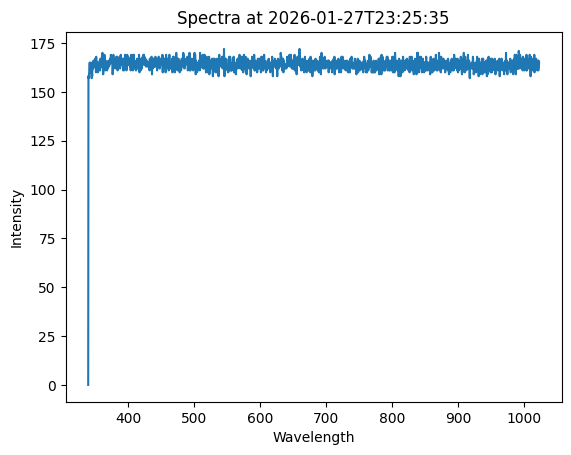

In [17]:
# Experiment Prep
# Test Spectra for integration time
dist = 20 #mm from top of gel

int_time = 10000 #np.multiply(int_time_s, 1E6) #microseconds

#Take spectra
spectra = get_spectra(int_time)
timestamp = get_time().split('.')[0]

data = {'Wavelength':spectra[0], 'Intensity':spectra[1]}
spectra = pd.DataFrame(data)
plt.plot(spectra['Wavelength'], spectra['Intensity'])
plt.title(f'Spectra at {timestamp}')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

### Create Experiment Folder

In [8]:
Experiment_Name = '260131_CoCl2_1wtAgar'
Exp_folder_path = Path(Experiment_Name)
print(Exp_folder_path)
Exp_folder_path.mkdir(parents=True, exist_ok=True)

260131_CoCl2_1wtAgar


### Cover instrument sensor

In [7]:
dist = 20 #mm from top of gel

int_time = 10000
fast_int_time = 10000 #microseconds

# Number of dark and fast spectra
dark_spec_count = 1
fast_spec_count = 1

dark_spectra = []
dark_times = []

for i in range(dark_spec_count):
    spec.integration_time_micros(int_time)
    intensity = spec.intensities()
    timestamp = get_time()
    dark_spectra.append(intensity)
    dark_times.append(timestamp)

fast_spectra = []
fast_times = []

for i in range(fast_spec_count):
    spec.integration_time_micros(int_time)
    intensity = spec.intensities()
    timestamp = get_time()
    fast_spectra.append(intensity)
    fast_times.append(timestamp)

wavelengths = spec.wavelengths() # from spectrometer

experiment_file_path = Exp_folder_path / 'Measurement.h5'

# Write dark spectra
write_specs_hdf5(
    experiment_file_path,
    "DarkSpectra",
    dark_spectra,
    dark_times,
    wavelengths,
    metadata={
        "integration_time_us": int_time,
        "type": "dark"
    }
)

# Write fast spectra
write_specs_hdf5(
    experiment_file_path,
    "FastSpectra",
    fast_spectra,
    fast_times,
    wavelengths,
    metadata={
        "integration_time_us": min_int_time,
        "type": "fast"
    }
)

In [8]:
filename = experiment_file_path
def print_h5_tree(name, obj):
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Group):
        print(f"{indent}{name}/")
    else:  # Dataset
        print(f"{indent}{name}  {obj.shape}  {obj.dtype}")

with h5py.File(filename, "r") as f:
    f.visititems(print_h5_tree)


DarkSpectra/
  DarkSpectra/spectra  (10, 2048)  float32
  DarkSpectra/timestamps  (10,)  object
  DarkSpectra/wavelengths  (2048,)  float32
FastSpectra/
  FastSpectra/spectra  (10, 2048)  float32
  FastSpectra/timestamps  (10,)  object
  FastSpectra/wavelengths  (2048,)  float32


### Taking a background with sample
Place sample in holder, open cover and turn source on\
Take a background measurement and record distance in the 'dist' variable

In [9]:
dist = 20

### DOUBLE CHECK INTEGRATION TIME ###

int_time = 10000 #microseconds 

#####################################

spec.integration_time_micros(int_time)

background = spec.intensities()
wavelengths = spec.wavelengths()
timestamp = get_time()

write_specs_hdf5(
    experiment_file_path,
    "Background",
    spectra_list=[background],
    time_list=[timestamp],
    wavelengths=wavelengths,
    metadata={
        "integration_time_us": int_time,
        "distance": dist,
        "type": "background"
    }
)


In [10]:
with h5py.File(filename, "r") as f:
    f.visititems(print_h5_tree)

Background/
  Background/spectra  (1, 2048)  float32
  Background/timestamps  (1,)  object
  Background/wavelengths  (2048,)  float32
DarkSpectra/
  DarkSpectra/spectra  (10, 2048)  float32
  DarkSpectra/timestamps  (10,)  object
  DarkSpectra/wavelengths  (2048,)  float32
FastSpectra/
  FastSpectra/spectra  (10, 2048)  float32
  FastSpectra/timestamps  (10,)  object
  FastSpectra/wavelengths  (2048,)  float32


### Running the experiment
After running the background, add the ion solution and run the cell\
The final .h5 file the format

```
<experiment_file>.h5
│
├── /Background
│   ├── spectra        float32 [1, λ]
│   ├── timestamps     float64 [1]
│   ├── wavelengths    float32 [λ]
│   └── attrs
│       ├── integration_time_us
│       ├── distance
│       └── type = "background"
│
├── /Scans
│   ├── spectra        float32 [N, λ]  
│   ├── timestamps     float64 [N]
│   ├── wavelengths    float32 [λ]
│   └── attrs
│       ├── integration_time_us
│       ├── distance
│       └── type = "scan"
│
├── /DarkSpectra
│   ├── spectra        float32 [N_dark, λ]
│   ├── timestamps     float64 [N_dark]
│   ├── wavelengths    float32 [λ]
│   └── attrs
│       ├── integration_time_us
│       └── type = "dark"
│
└── /FastSpectra
    ├── spectra        float32 [N_fast, λ]
    ├── timestamps     float64 [N_fast]
    ├── wavelengths    float32 [λ]
    └── attrs
        ├── integration_time_us
        └── type = "fast"

```

In [11]:
### CHECK INTEGRATION TIME ###

int_time = 10000

##############################

spec.integration_time_micros(int_time)
wavelengths = spec.wavelengths()

stop_flag = False

def input_listener():
    global stop_flag
    while True:
        cmd = input()
        if cmd.lower().strip() == "quit":
            stop_flag = True
            break

threading.Thread(target=input_listener, daemon=True).start()

scan_interval = 60.0  # seconds
next_scan_time = time.time()

count = 0

while not stop_flag:
    now = time.time()

    if now >= next_scan_time:
        timestamp = get_time()
        intensity = spec.intensities()

        append_scan_hdf5(
            experiment_file_path,
            "Scans",
            spectrum=intensity,
            timestamp=timestamp,
            wavelengths=wavelengths,
            metadata={
                "integration_time_us": int_time,
                "distance": dist,
                "type": "scan"
            }
        )

        #print(f"Scan {count:05d} at {timestamp}")

        ## Plotter ##
        # Read the experiment file
        with h5py.File(experiment_file_path, "r") as f:
            wavelengths = f["Scans"]["wavelengths"][:]
            background = f["Background"]["spectra"][:]
            spectra = f["Scans"]["spectra"][:-1]
            timestamp = f["Scans"]["timestamps"][-1].decode("utf-8")
        
        # Plot the data  
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        
        ax[0].plot(wavelengths, spectra[0])
        ax[0].set_title(f'Raw Spectra #{count} at {timestamp[:-14]}')
        ax[0].set_xlabel('Wavelength')
        ax[0].set_ylabel('Intensity (counts)')
        
        I = np.multiply(np.subtract(spectra[1], background), -1)
        I_0 = np.multiply(background, -1)
        extinction = np.log10(I, I_0)
        
        ax[1].plot(spectra[0], extinction[0])
        ax[1].set_title(f'Extinction Spectra #{count} at {timestamp[:-14]}')
        ax[1].set_xlabel('Wavelength')
        ax[1].set_ylabel('Extinction (arb. u.)')
        
        #############

        
        count += 1
        next_scan_time += scan_interval

    time.sleep(0.2)

print("Acquisition stopped cleanly.")


Scan 00000 at 2026-01-27T19:09:23.032888+00:00
Scan 00001 at 2026-01-27T19:10:23.186714+00:00
Scan 00002 at 2026-01-27T19:11:23.183765+00:00
Scan 00003 at 2026-01-27T19:12:23.195184+00:00
Scan 00004 at 2026-01-27T19:13:23.168668+00:00
Scan 00005 at 2026-01-27T19:14:23.165985+00:00
Scan 00006 at 2026-01-27T19:15:23.170387+00:00
Scan 00007 at 2026-01-27T19:16:23.158798+00:00
Scan 00008 at 2026-01-27T19:17:23.178334+00:00
Scan 00009 at 2026-01-27T19:18:23.164728+00:00
Scan 00010 at 2026-01-27T19:19:23.169081+00:00
Scan 00011 at 2026-01-27T19:20:23.173920+00:00


 quit


Acquisition stopped cleanly.


In [12]:
with h5py.File(filename, "r") as f:
    f.visititems(print_h5_tree)

Background/
  Background/spectra  (1, 2048)  float32
  Background/timestamps  (1,)  object
  Background/wavelengths  (2048,)  float32
DarkSpectra/
  DarkSpectra/spectra  (10, 2048)  float32
  DarkSpectra/timestamps  (10,)  object
  DarkSpectra/wavelengths  (2048,)  float32
FastSpectra/
  FastSpectra/spectra  (10, 2048)  float32
  FastSpectra/timestamps  (10,)  object
  FastSpectra/wavelengths  (2048,)  float32
Scans/
  Scans/spectra  (12, 2048)  float32
  Scans/timestamps  (12,)  object
  Scans/wavelengths  (2048,)  float32


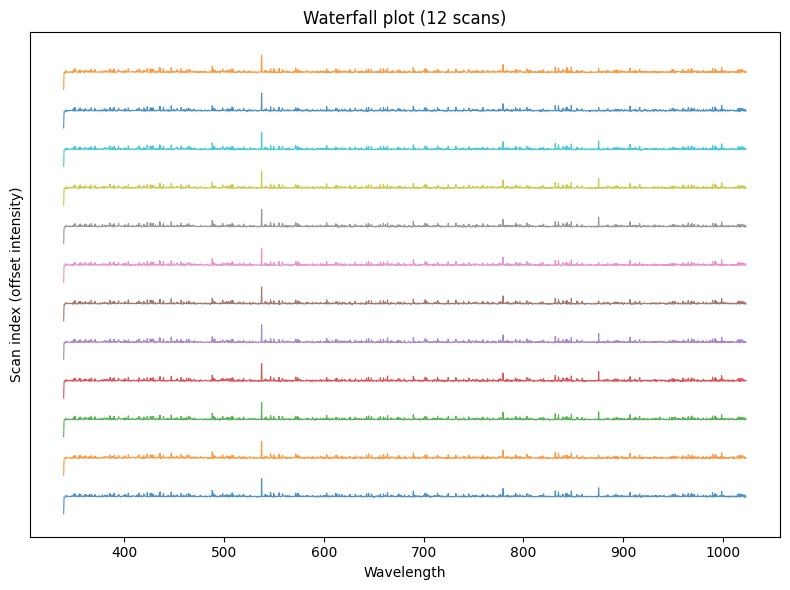

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

filename = experiment_file_path   # or "your_file.h5"
group = "Scans"

with h5py.File(filename, "r") as f:
    g = f[group]
    wavelengths = g["wavelengths"][:]
    spectra = g["spectra"][:]
    timestamps = g["timestamps"][:].astype(str)

n_scans = spectra.shape[0]

# choose vertical spacing automatically
offset = 1.1 * np.nanmax(spectra)

plt.figure(figsize=(8, 6))

for i in range(n_scans):
    plt.plot(
        wavelengths,
        spectra[i] + i * offset,
        lw=0.8,
        alpha=0.8
    )

plt.xlabel("Wavelength")
plt.ylabel("Scan index (offset intensity)")
plt.title(f"Waterfall plot ({n_scans} scans)")
plt.yticks([])  # cleaner look
plt.tight_layout()
plt.show()


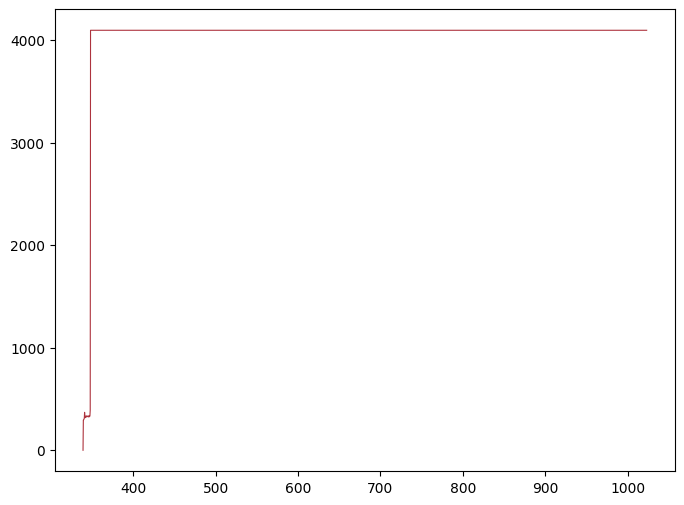

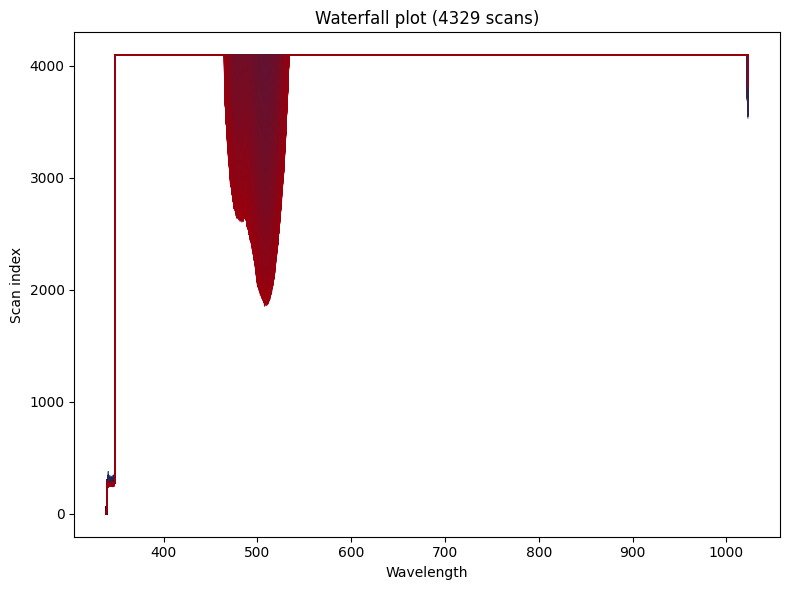

In [46]:
filename = Path('/home/zrwylie/UVVisScan/Scanning-UVVis-4mmNMRTube/Test_0/SpectrometerCalibration.h5')

group = "Scans"

with h5py.File(filename, "r") as f:
    g = f[group]
    wavelengths = g["wavelengths"][:]
    background = f["Background"]["spectra"][:]
    spectra = g["spectra"][:-1]
    timestamps = g["timestamps"][:].astype(str)

n_scans = spectra.shape[0]

color_list = custom_multicolor_cmap(n_scans, '#08306b', '#99000d')

# Background Subtraction
bkg_subbed_spectra = spectra - background

plt.figure(figsize=(8, 6))
plt.plot(
        wavelengths,
        background[0][:],
        color=color,
        lw=0.8,
        alpha=0.8
    )


plt.figure(figsize=(8, 6))

for i in range(n_scans):
    color = color_list[i]
    plt.plot(
        wavelengths,
        spectra[i],
        color=color,
        lw=0.8,
        alpha=0.8
    )

plt.xlabel("Wavelength")
plt.ylabel("Scan index")
plt.title(f"Waterfall plot ({n_scans} scans)")
#plt.yticks([])  # cleaner look
plt.tight_layout()
plt.show()

/tmp/ipykernel_260567/993564096.py:24: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(np.divide(bkg_subbed_spectra, dark_subbed_background))
/tmp/ipykernel_260567/993564096.py:24: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(np.divide(bkg_subbed_spectra, dark_subbed_background))
/tmp/ipykernel_260567/993564096.py:24: RuntimeWarning: invalid value encountered in log10
  absorbance = np.log10(np.divide(bkg_subbed_spectra, dark_subbed_background))


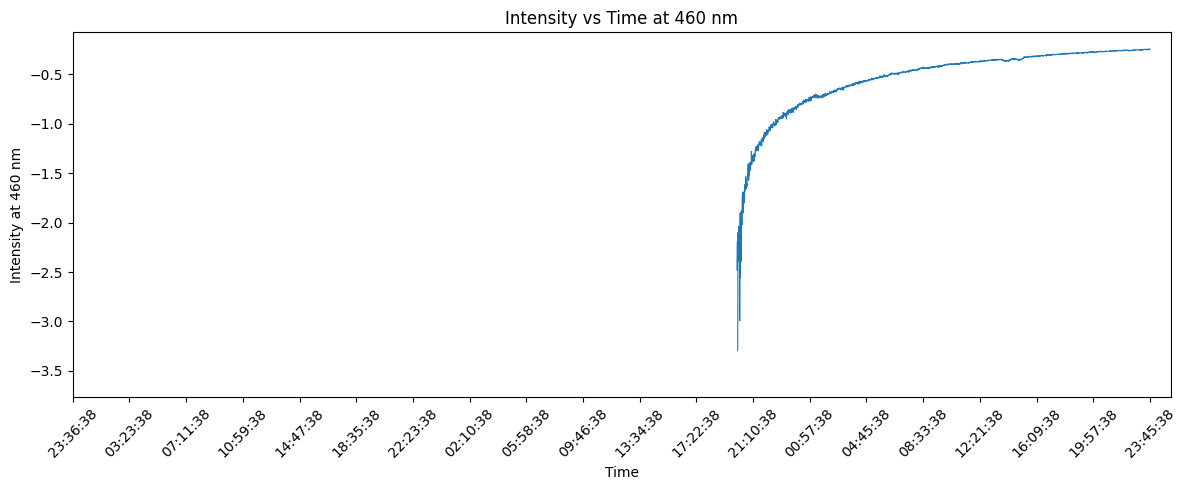

In [56]:
filename = Path('/home/zrwylie/UVVisScan/Scanning-UVVis-4mmNMRTube/Test_0/SpectrometerCalibration.h5')
group = "Scans"

with h5py.File(filename, "r") as f:
    g = f[group]
    wavelengths = g["wavelengths"][:]
    darkscan = f['DarkSpectra']['spectra'][0]
    background = f["Background"]["spectra"][:]
    spectra = g["spectra"][:]
    timestamps = g["timestamps"][:].astype(str)

# Convert timestamps to datetime objects for nicer plotting
timestamps_dt = [datetime.fromisoformat(ts.replace("Z", "+00:00")) for ts in timestamps]

# 

# Find the index closest to 460 nm
target_wavelength = 460
wavelength_idx = 460 #np.argmin(np.abs(wavelengths - target_wavelength))

# Extract intensity at 460 nm for all scans
intensity_at_460 = absorbance[:, wavelength_idx]

# Plot intensity vs time
plt.figure(figsize=(12, 5))
plt.plot(timestamps_dt, intensity_at_460, lw=0.8)

# Only show x-axis labels every N points to avoid clutter
n_ticks = 20  # number of ticks you want
tick_indices = np.linspace(0, len(timestamps_dt)-1, n_ticks, dtype=int)
plt.xticks([timestamps_dt[i] for i in tick_indices],
           [timestamps_dt[i].strftime("%H:%M:%S") for i in tick_indices],
           rotation=45)

plt.xlabel("Time")
plt.ylabel(f"Intensity at {target_wavelength} nm")
plt.title(f"Intensity vs Time at {target_wavelength} nm")
plt.tight_layout()
plt.show()

In [40]:
print(wavelengths)

[ 339.11313  339.49292  339.8727  ... 1022.3506  1022.6303  1022.91   ]


[   0.  299.  300. ... 4095. 4095. 4095.]
[   0.  288.  298. ... 4095. 4095. 3802.]


/tmp/ipykernel_264239/2254486540.py:21: RuntimeWarning: divide by zero encountered in log10
  extinction = np.log10(I, I_0)
/tmp/ipykernel_264239/2254486540.py:21: RuntimeWarning: invalid value encountered in log10
  extinction = np.log10(I, I_0)


Text(0, 0.5, 'Extinction (arb. u.)')

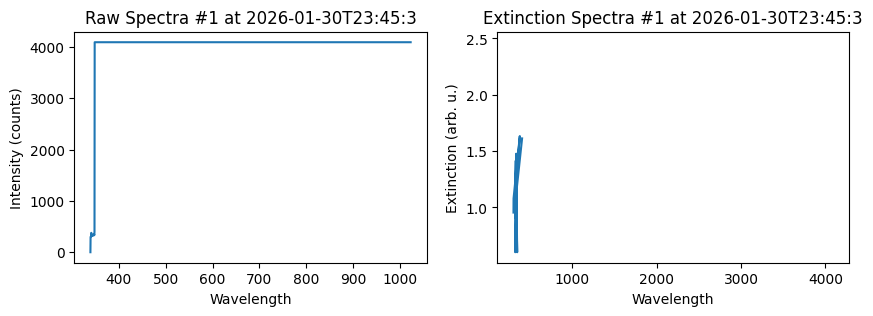

In [51]:
experiment_file_path = '/home/zrwylie/UVVisScan/Scanning-UVVis-4mmNMRTube/Test_0/SpectrometerCalibration.h5'
count = 1
with h5py.File(experiment_file_path, "r") as f:
    wavelengths = f["Scans"]["wavelengths"][:]
    background = f["Background"]["spectra"][:]
    spectra = f["Scans"]["spectra"][:-1]
    timestamp = f["Scans"]["timestamps"][-1].decode("utf-8")

# Plot the data  
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(wavelengths, spectra[0])
ax[0].set_title(f'Raw Spectra #{count} at {timestamp[:-14]}')
ax[0].set_xlabel('Wavelength')
ax[0].set_ylabel('Intensity (counts)')

I = np.multiply(np.subtract(spectra[1], background), -1)
I_0 = np.multiply(background, -1)
extinction = np.log10(I, I_0)

ax[1].plot(spectra[0], extinction[0])
ax[1].set_title(f'Extinction Spectra #{count} at {timestamp[:-14]}')
ax[1].set_xlabel('Wavelength')
ax[1].set_ylabel('Extinction (arb. u.)')